<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [56]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
!unzip '/content/drive/MyDrive/Копия archive.zip' -d 'faces_data'

Archive:  /content/drive/MyDrive/Копия archive.zip
replace faces_data/faces_dataset_small/00055.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [59]:
image_size = 64
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
DATA_DIR = './faces_data'

In [60]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader

  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [61]:
train_dl = get_dataloader(image_size, batch_size)
#TODO: build dataloader and transfer it to device

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device


device(type='cuda')

In [62]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [63]:
from torchvision.models import vgg16

In [64]:
vgg = vgg16(pretrained=True)

In [65]:
class discriminator(nn.Module):
    def __init__(self, n_classes):
        super(discriminator, self).__init__()
        self.vgg = vgg16(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False
        num_ftrs = self.vgg.classifier[0].in_features
        self.vgg.classifier = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        return self.vgg(x)

In [66]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Dropout(0.4),
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid())

discriminator_model = discriminator.to(device)

In [67]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(8) # 1 -> 8
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(latent_size, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(16) # 8 -> 16
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(3, 3), padding=(1, 1)),
            nn.Tanh()
        )

    def forward(self, x):

        # decoder
        d0 = self.dec_conv0(self.upsample0(x))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))
          # no activation
        return d3

In [68]:
latent_size = 128 # choose latent size

# generator = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # out: 512 x 4 x 4

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # out: 256 x 8 x 8

#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # out: 128 x 16 x 16

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 64 x 64
# )

generator = generator().to(device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [69]:
lr = 0.0001

model = {
    "discriminator": discriminator_model,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [70]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [71]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [72]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [73]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [74]:
def fit(model, criterion, epochs, lr, start_idx=1):
    # TODO: build optimizers and train your GAN
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            # print(real_images.shape,real_preds.shape)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [75]:

lr = 1e-4
epochs = 20

In [76]:


history = fit(model, criterion, epochs, lr)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 3.1504, loss_d: 1.5756, real_score: 0.5505, fake_score: 0.4466


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 1.3030, loss_d: 1.5204, real_score: 0.5064, fake_score: 0.5093


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 1.1132, loss_d: 1.4579, real_score: 0.5059, fake_score: 0.5016


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 1.2444, loss_d: 1.4418, real_score: 0.5131, fake_score: 0.4955


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 1.0361, loss_d: 1.4611, real_score: 0.4972, fake_score: 0.5040


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 1.0005, loss_d: 1.4751, real_score: 0.4919, fake_score: 0.5072


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 1.0522, loss_d: 1.4633, real_score: 0.4947, fake_score: 0.5085


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 0.9836, loss_d: 1.4626, real_score: 0.4914, fake_score: 0.5072


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 0.9552, loss_d: 1.4476, real_score: 0.4946, fake_score: 0.5065


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 0.9422, loss_d: 1.4380, real_score: 0.4948, fake_score: 0.5039


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 0.9572, loss_d: 1.4307, real_score: 0.4958, fake_score: 0.5013


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 0.9225, loss_d: 1.4330, real_score: 0.4928, fake_score: 0.5019


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 1.0567, loss_d: 1.4140, real_score: 0.5020, fake_score: 0.4969


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 0.9734, loss_d: 1.4214, real_score: 0.4984, fake_score: 0.4985


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 0.9511, loss_d: 1.4310, real_score: 0.4942, fake_score: 0.5017


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 1.0481, loss_d: 1.3952, real_score: 0.5061, fake_score: 0.4924


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 0.9826, loss_d: 1.4374, real_score: 0.4945, fake_score: 0.5029


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 1.1090, loss_d: 1.3952, real_score: 0.5052, fake_score: 0.4909


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 1.0506, loss_d: 1.4021, real_score: 0.5040, fake_score: 0.4923


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 1.0597, loss_d: 1.3833, real_score: 0.5102, fake_score: 0.4881
Saving generated-images-0020.png


In [77]:
losses_g, losses_d, real_scores, fake_scores = history

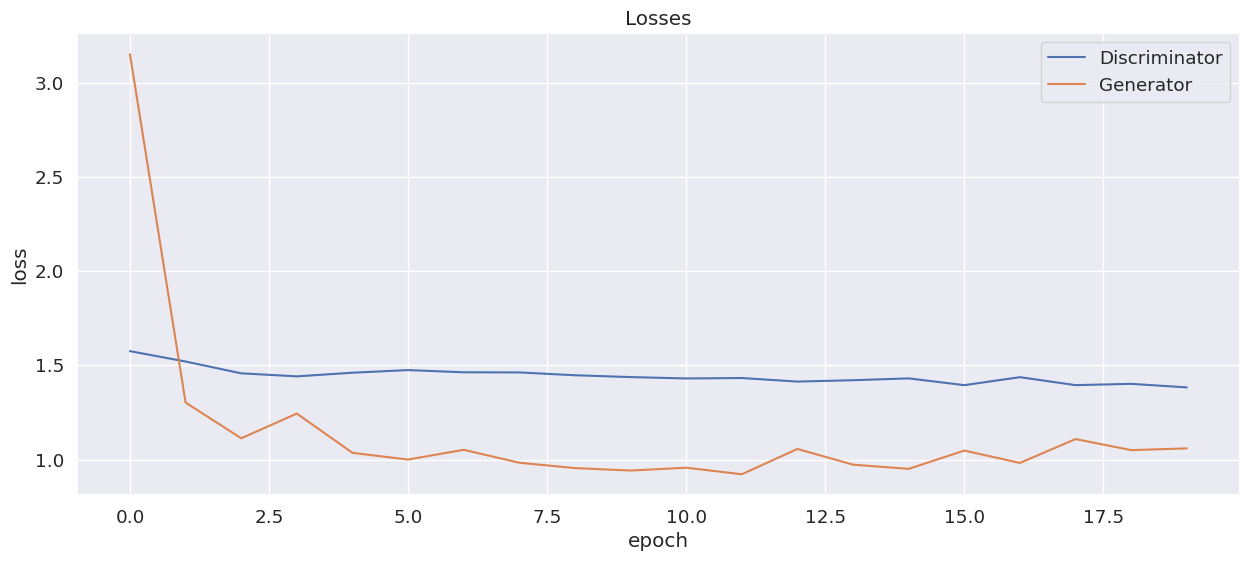

In [78]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

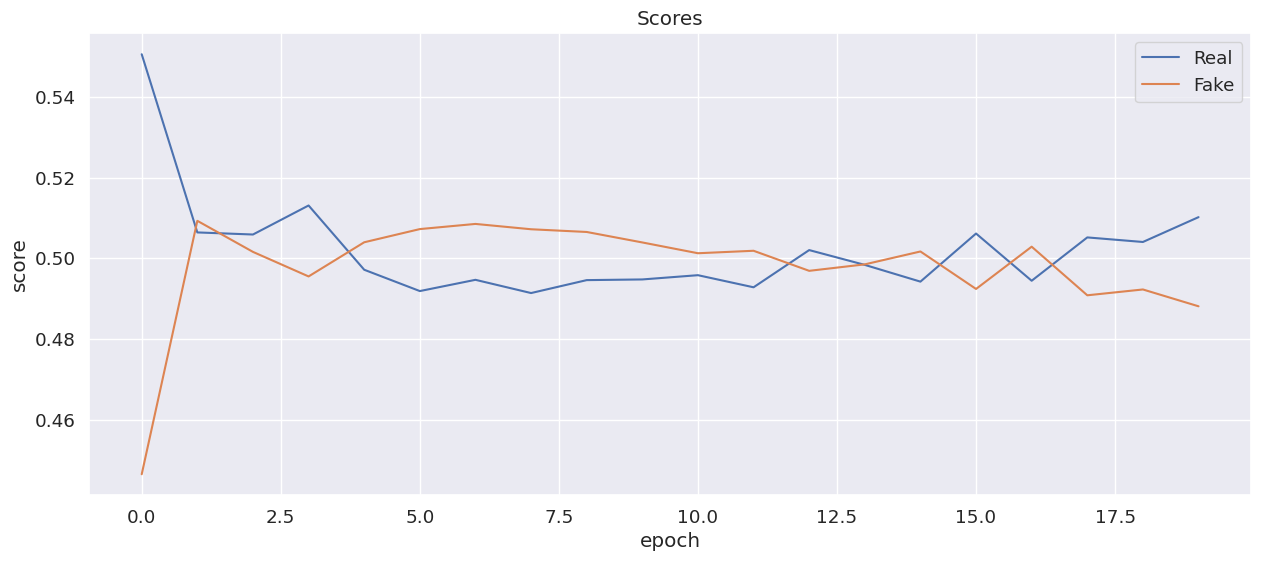

In [79]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [80]:
torch.save(discriminator.state_dict(), 'discriminator_model')
torch.save(generator.state_dict(), 'generator_model')

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [81]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [82]:
def show_images(images, nmax=n_images):
  # TODO: show generated images
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [83]:
def show_batch(dl, nmax=n_images):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [84]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

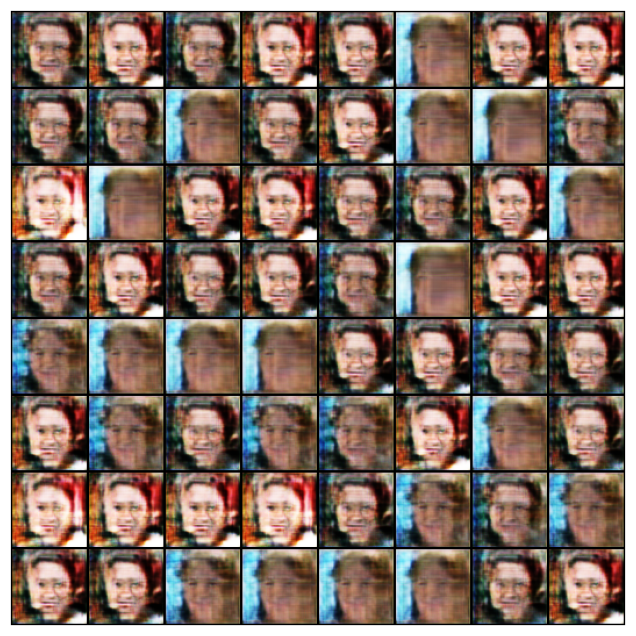

In [85]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: